# TCNN Classifier

In [151]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import sys
import numpy as np
import random
from sklearn.metrics import accuracy_score
import time
import json

sys.path.append('../scripts')
import ml_helper as mlh
import ml_evaluation as mle
import Tcnn
from Tcnn import TemporalConvNet

In [152]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
data_path = '../data'

Code inspiered:

https://de.mathworks.com/help/deeplearning/ug/sequence-to-sequence-classification-using-1-d-convolutions.html

References:

- [1] Bai, Shaojie, J. Zico Kolter, and Vladlen Koltun. “An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling.” Preprint, submitted April 19, 2018. https://arxiv.org/abs/1803.01271.

- [2] Oord, Aaron van den, Sander Dieleman, Heiga Zen, Karen Simonyan, Oriol Vinyals, Alex Graves, Nal Kalchbrenner, Andrew Senior, and Koray Kavukcuoglu. “WaveNet: A Generative Model for Raw Audio.” Preprint, submitted September 12, 2016. https://arxiv.org/abs/1609.03499.

- [3] Tompson, Jonathan, Ross Goroshin, Arjun Jain, Yann LeCun, and Christoph Bregler. “Efficient Object Localization Using Convolutional Networks.” 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 648–56. https://doi.org/10.1109/CVPR.2015.7298664.


In [154]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [155]:
SEED = 42
def set_seed(SEED=SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
set_seed()

### Data Preparation

In [156]:
# Data preparation
organisms = ["E.Coli", "Drosophila.Melanogaster", "Homo.Sapiens"]
organism = organisms[0]
pad_int = mlh.codons.index('___')
#"Homo.Sapiens"  "Drosophila.Melanogaster"  "E.Coli"
min_length = None
max_length = 500
one_hot = True
cut_data = False

SPEEDS_ADDED = False
BATCH_SIZE = 32

In [157]:
train_dataset = mlh.CodonDataset(organism, "train", min_length, max_length, cut_data=True, one_hot_aa=one_hot, data_path=data_path, device=device)
print(f"Länge train_dataset: {len(train_dataset)}")
test_dataset = mlh.CodonDataset(organism, "test", min_length, max_length, cut_data=True, one_hot_aa=one_hot, data_path=data_path, device=device)
print(f"Länge test_dataset: {len(test_dataset)}")
valid_dataset = mlh.CodonDataset(organism, "valid", min_length, max_length, cut_data=True, one_hot_aa=one_hot, data_path=data_path, device=device)
print(f"Länge valid_dataset: {len(valid_dataset)}")

Länge train_dataset: 3555
Länge test_dataset: 444
Länge valid_dataset: 420


In [158]:
# train_dataset = mlh.CodonDataset(organism, "train", add_speeds=SPEEDS_ADDED, cut_data=cut_data, one_hot_aa=one_hot, data_path=data_path, device=device)
# print(f"Länge train_dataset: {len(train_dataset)}")
# test_dataset = mlh.CodonDataset(organism, "test", add_speeds=SPEEDS_ADDED, cut_data=cut_data, one_hot_aa=one_hot, data_path=data_path, device=device)
# print(f"Länge test_dataset: {len(test_dataset)}")
# valid_dataset = mlh.CodonDataset(organism, "valid", add_speeds=SPEEDS_ADDED, cut_data=cut_data, one_hot_aa=one_hot, data_path=data_path, device=device)
# print(f"Länge valid_dataset: {len(valid_dataset)}")

In [159]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Hyperparameters and Model Initialization

In [160]:
best_params = Tcnn.load_best_params(organism)
if best_params is not None:
    print(f"Best parameters: num_filters: {best_params[0]}, filter_size: {best_params[1]}, dropout_factor: {best_params[2]}, num_blocks: {best_params[3]}, parallel_layer: {best_params[4]}, learing_rate: {best_params[5]}")

Best parameters: num_filters: 256, filter_size: 3, dropout_factor: 0.08, num_blocks: 3, parallel_layer: False, learing_rate: 0.001


In [161]:
# Hyperparameters
num_features = len(mlh.amino_acids)
num_classes = len(mlh.codons)  # number of codons (output classes)
NUM_EPOCHS = 200

num_filters = 128 #64
filter_size = 5#3  # NOTE: filter size must be unequal like: 3,5,9,...
dropout_factor = 0.08 #0.08 #0.005
num_blocks = 5#2
parallel_layer = True
learing_rate = 0.001 # 0.001

if best_params is not None:
    num_filters = best_params[0]
    filter_size = best_params[1]
    dropout_factor = best_params[2]
    num_blocks = best_params[3]
    parallel_layer = best_params[4]
    learing_rate = best_params[5]


# Model
tcnModel = Tcnn.TemporalConvNet(num_features, num_classes, num_filters, filter_size, 
                        dropout_factor, num_blocks, parallel_layer)
print(tcnModel)

#criterion = nn.CrossEntropyLoss(ignore_index=64)
criterion = nn.CrossEntropyLoss(ignore_index=pad_int)
optimizer = optim.Adam(tcnModel.parameters(), lr=learing_rate)

TemporalConvNet(
  (layers): ModuleList(
    (0): Conv1d(22, 256, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.08, inplace=False)
    (5): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.08, inplace=False)
    (8): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.08, inplace=False)
    (12): Softmax(dim=1)
  )
)


### Start Training

In [162]:
trainings_losses, trainings_accuracies, valid_accs, best_epoch_idx = Tcnn.train(tcnModel, train_loader, valid_loader, NUM_EPOCHS, optimizer, criterion, device=device)

Epoch [1/200], Loss: 5.231, accuracy: 0.47, valid acc: 0.54
Epoch [2/200], Loss: 5.138, accuracy: 0.519, valid acc: 0.545
Epoch [3/200], Loss: 5.105, accuracy: 0.523, valid acc: 0.545
Epoch [4/200], Loss: 5.084, accuracy: 0.524, valid acc: 0.547
Epoch [5/200], Loss: 5.072, accuracy: 0.524, valid acc: 0.545
Epoch [6/200], Loss: 5.064, accuracy: 0.524, valid acc: 0.547
Epoch [7/200], Loss: 5.057, accuracy: 0.526, valid acc: 0.547
Epoch [8/200], Loss: 5.053, accuracy: 0.527, valid acc: 0.548
Epoch [9/200], Loss: 5.049, accuracy: 0.528, valid acc: 0.549
Epoch [10/200], Loss: 5.046, accuracy: 0.528, valid acc: 0.55
Epoch [11/200], Loss: 5.044, accuracy: 0.529, valid acc: 0.55
Epoch [12/200], Loss: 5.042, accuracy: 0.53, valid acc: 0.55
Epoch [13/200], Loss: 5.039, accuracy: 0.531, valid acc: 0.55
Epoch [14/200], Loss: 5.038, accuracy: 0.531, valid acc: 0.551
Epoch [15/200], Loss: 5.037, accuracy: 0.531, valid acc: 0.55
Epoch [16/200], Loss: 5.036, accuracy: 0.531, valid acc: 0.551
Epoch [17

In [163]:
json_data = {'organism': organism, 'training_valid_accs': valid_accs, 'best_epoch_idx': best_epoch_idx}

# Save training valid accuracies
acc_path = data_path + f'/{organism}/training_valid_accs.json'

with open(acc_path, 'w') as file:
    json.dump(json_data, file)

print('Vaild Accs in training saved in:', acc_path)

Vaild Accs in training saved in: ../data/E.Coli/training_valid_accs.json


### Save the model

In [164]:
mlh.save_model(tcnModel, f'tcn_valid_acc_{round(round(valid_accs[-1],2) * 100)}', organism)

Model saved as 20240627113322_tcn_valid_acc_55.pt


### Load the model

In [165]:
tcnModel = mlh.load_model(f'tcn', organism, device=device)

Model loaded: 20240627113322_tcn_valid_acc_55.pt


### Evaluation of the model

In [166]:
predicted, labels, accuracies = Tcnn.evaluate_model(tcnModel, device, test_loader, codon_names=False)

#### Get codon names and associated amino acids

In [167]:
predicted = predicted.cpu().numpy()
labels = labels.cpu().numpy()

predicted, labels = mle.filter_padding(predicted, labels, filter_value=pad_int)

predicted_codon_names =  mle.codon_to_name(predicted)
labels_codon_names =  mle.codon_to_name(labels)

predicted_aa =  mle.translate_codons(predicted_codon_names)
labels_aa =  mle.translate_codons(labels_codon_names)

mle.get_unique_pred_classes(predicted_codon_names, labels_codon_names)
mle.print_unique_elements(predicted_aa, labels_aa)

predicted different classes:  56 out of: 61
predicted following classes:  {'AAA', 'AGC', 'CGG', 'AAC', 'CAG', 'CGT', 'TGT', 'TAC', 'CTG', 'TTA', 'GGC', 'CCA', 'GAA', 'AGT', 'CAT', 'CGC', 'GTT', 'ACC', 'TGC', 'TCC', 'GTC', 'GCG', 'CCG', 'CTT', 'ATT', 'TCT', 'TTC', 'GGG', 'GCT', 'GCA', 'CAC', 'ACA', 'CTC', 'GCC', 'ATG', 'ATC', 'TTG', 'TCG', 'TCA', 'CCC', 'ACT', 'GGA', 'TAT', 'TGG', 'ACG', 'CAA', 'CCT', 'GAT', 'GGT', 'GAC', 'AAT', 'TTT', 'GTA', 'GTG', 'AAG', 'GAG'}
predicted different amino acids:  20 out of: 20


#### Accuracies

In [168]:
test_dataset = mlh.CodonDataset(organism=organism, split="test", padding_pos=None, one_hot_aa=False)
test_loader = DataLoader(test_dataset, batch_size=1)
print(f"Datensatz geladen für {organism}")

classifier = Tcnn.Tcn_Classifier(tcnModel)
predictions = classifier.predict_codons(test_loader, codon_names=False)

labels = []
for seq, lab in test_dataset:
    lab = [int(c.item()) for c in lab]
    labels.append(lab)

acc = classifier.calc_accuracy(labels, predictions, pad='')
print(organism, acc)

Datensatz geladen für E.Coli
E.Coli 0.5556605604448457


## Plots

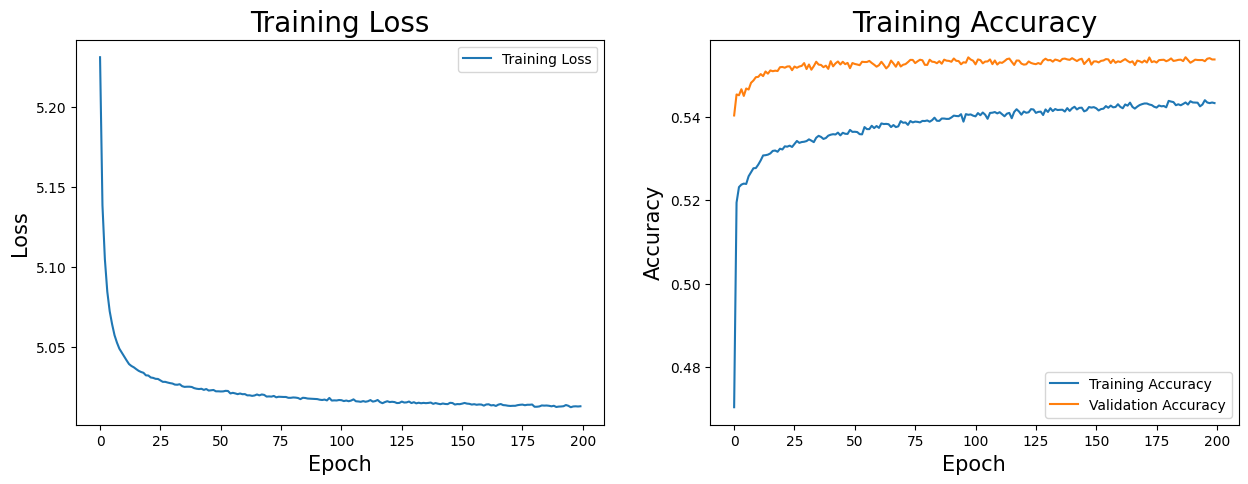

In [169]:
# check if training losses and accuracies is defined
if 'trainings_losses' in locals() and 'trainings_accuracies' in locals():
    # plot of training loss and accuracy
    plt = mle.plot_training(trainings_losses, trainings_accuracies, valid_accs)
    plt.show()
else:
    print("No training losses and accuracies available")

## Hyperparamter Grid Search

In [170]:
%%time

# Hyperparameters
params = {
    "num_filters": [64, 128, 256],
    "filter_size": [3, 5, 9],
    "dropout_factor": [0.08],
    "num_blocks": [3, 5, 7],
    "parallel_layer": [True, False],
    "learing_rate": [0.001]
}

# Hyperparameter search
#results, best_model = Tcnn.hyperparam_search(organism, train_loader, valid_loader, params, num_features, num_classes, device, criterion)

CPU times: user 9 µs, sys: 1e+03 ns, total: 10 µs
Wall time: 14.1 µs


In [171]:
if 'results' in locals():
    for r in results[:10]:
        print(r)

    # print best parameters
    best_params = results[np.argmax([r[-1] for r in results])]
    print(f"Best parameters: num_filters: {best_params[0]}, filter_size: {best_params[1]}, dropout_factor: {best_params[2]}, num_blocks: {best_params[3]}, parallel_layer: {best_params[4]}, learing_rate: {best_params[5]}, acc: {round(best_params[6], 3)}")
    # save results as json
    path = f'../ml_models/{organism}/tcnn_grid_search_results.json'
    with open(path, 'w') as f:
        json.dump(results, f)


    # save best model
    mlh.save_model(best_model, f'tcnn_best_model_acc_{round(max([r[-1] for r in results]),3)}', organism)